# Constrained Airplane Design

In this notebook we simulate the design of an airplane's component using constrained bayesian optimsation.

We will begin by defining the latent objective function as well as the latent cost function.

In [1]:
from jax import config

config.update("jax_enable_x64", True)

from jax import numpy as jnp
from jax import jit, lax, nn, random, value_and_grad

import optax
import matplotlib.pyplot as plt

plt.style.use('bmh')

from boax import prediction, optimization
from boax.core import distributions, samplers
from boax.prediction import kernels, likelihoods, means, models, objectives
from boax.optimization import acquisitions, constraints, optimizers

In [2]:
data_key, sampler_key, optimizer_key = random.split(random.key(0), 3)

In [3]:
bounds = jnp.array([[0.0, 1.0]] * 4)

In [4]:
axis = ['scaled body length', 'scaled wing span', 'scaled ρ', 'scaled ω']

In [5]:
def objective(x):
    next_x = x.at[:, [2, 3]].set(1 - x[:, [2, 3]]) * 10 - 5
    return -0.005 * jnp.sum(next_x ** 4 - 16 * next_x ** 2 + 5 * next_x, axis=-1) + 3

In [6]:
def cost(x):
    i = jnp.arange(2, 5)
    next_x = x * 20 - 10
    part1 = (next_x[..., 0] - 1)**2
    part2 = jnp.sum(i * (2 * next_x[..., 1:]**2 - next_x[..., :-1])**2, axis=-1)

    return -(part1 + part2) / 100_000 + 2

In [7]:
x_train = random.uniform(data_key, minval=bounds[:, 0], maxval=bounds[:, 1], shape=(1, 4))
y_train = objective(x_train)
c_train = cost(x_train)

In [8]:
grid = jnp.linspace(0, 1, 101)
x1, x2 = jnp.meshgrid(grid, grid, indexing="ij")
xs = jnp.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)

In [9]:
def visualize(fn):
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    dimensions_to_plot = [(0, 1), (1, 2), (2, 3), (0, 3)]
    zeros = jnp.zeros((101 ** 2, 4))
    
    for idx, (i, j) in enumerate(dimensions_to_plot):
        ax = axs[idx // 2][idx % 2]

        ax.scatter(x_train[..., i], x_train[..., j], marker='x', c='k', label='observations')
        
        c = ax.imshow(
            fn(zeros.at[:, [i, j]].set(xs)).reshape(101, 101),
            origin='lower',
            extent=[0, 1, 0, 1],
        )
        
        plt.colorbar(c, ax=ax)
    
        ax.set_xlabel(axis[i], fontsize=15)
        ax.set_ylabel(axis[j], fontsize=15)
        ax.legend(loc='upper left')
    
    plt.show()

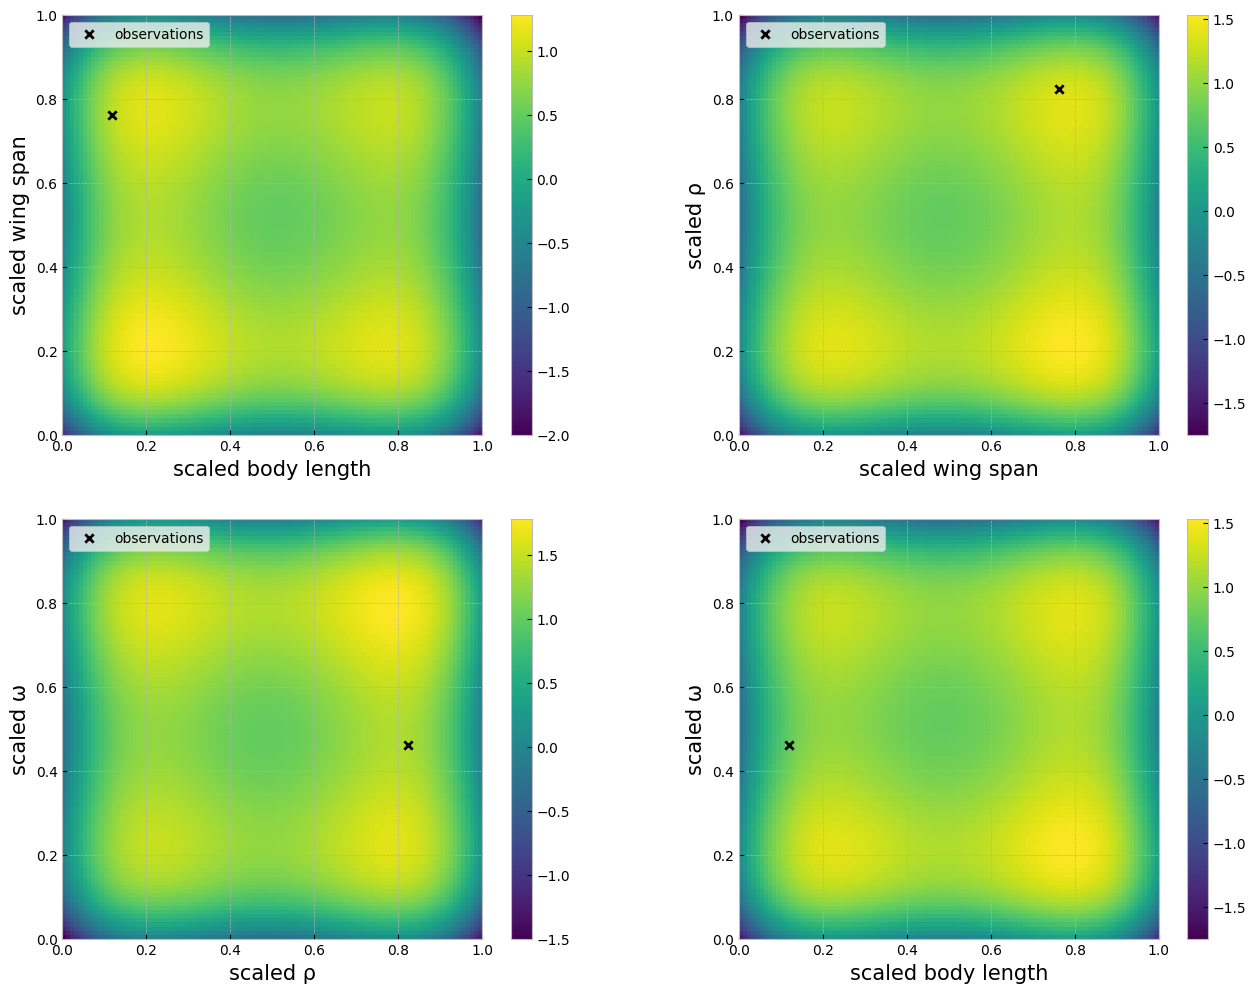

In [10]:
visualize(objective)

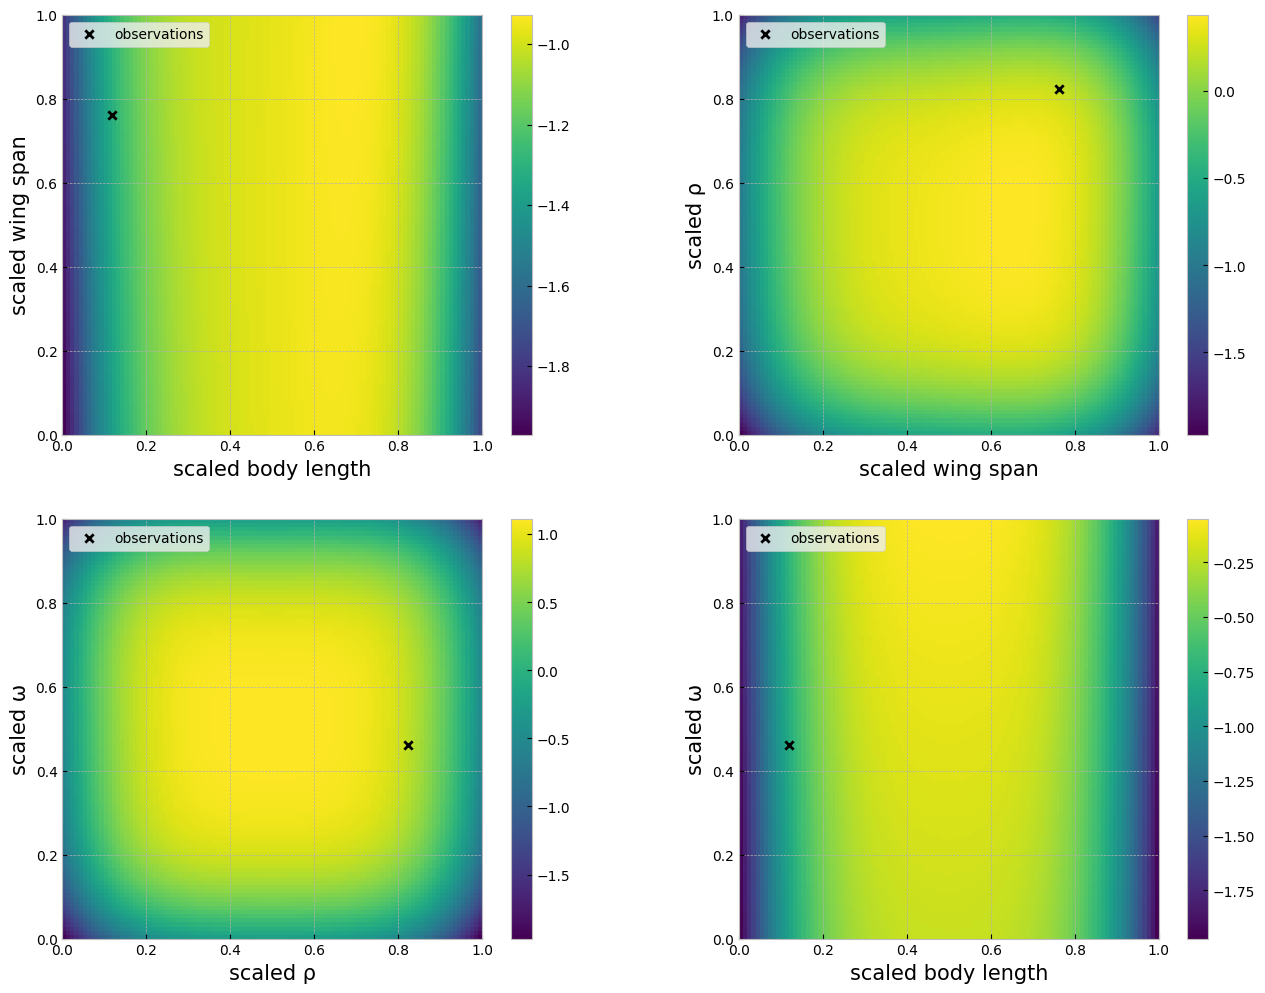

In [11]:
visualize(cost)

In [12]:
params = {
    'mean': jnp.zeros(()),
    'length_scale': jnp.zeros((4,)),
    'amplitude': jnp.zeros(()),
}

In [13]:
adam = optax.adam(0.01)

In [14]:
def fit(x_train, y_train):
    def prior(params):
        return models.outcome_transformed(
            models.gaussian_process(
                means.constant(params['mean']),
                kernels.scaled(
                    kernels.matern_five_halves(params['length_scale']),
                    params['amplitude'],
                ),
            ),
            likelihoods.gaussian(1e-4)
        )

    def posterior(params):
        return models.outcome_transformed(
            models.gaussian_process_regression(
                means.constant(params['mean']),
                kernels.scaled(
                    kernels.matern_five_halves(params['length_scale']),
                    params['amplitude'],
                ),
            )(
                x_train,
                y_train,
            ),
            likelihoods.gaussian(1e-4),
        )

    def objective(params):
        return objectives.negative_log_likelihood(
            distributions.multivariate_normal.logpdf
        )

    def projection(params):
        return {
            'mean': params['mean'],
            'amplitude': nn.softplus(params['amplitude']),
            'length_scale': nn.softplus(params['length_scale']),
        }
        
    def step(state, iteration):
        loss_fn = prediction.construct(prior, objective, projection)
        loss, grads = value_and_grad(loss_fn)(state[0], x_train, y_train)
        updates, opt_state = adam.update(grads, state[1])
        params = optax.apply_updates(state[0], updates)
        
        return (params, opt_state), loss
    
    (next_params, _), _ = lax.scan(
        jit(step),
        (params, adam.init(params)),
        jnp.arange(500)
    )

    return posterior(
        projection(next_params)
    )

In [15]:
x0 = jnp.reshape(
    samplers.halton_uniform(
        distributions.uniform.uniform(bounds[:, 0], bounds[:, 1])
    )(
        sampler_key,
        500 * 1,
    ),
    (500, 1, -1)
)

In [16]:
def optimize(key, acqf):
    bfgs = optimizers.bfgs(acqf, bounds, x0, 100)
    candidates = bfgs.init(key)
    next_candidates, values = bfgs.update(candidates)

    next_x = next_candidates[jnp.argmax(values)]
    next_y = objective(next_x)
    next_c = cost(next_x)

    return next_x, next_y, next_c

In [17]:
for i in range(30):
    feasible = y_train[c_train <= 0]
    best = jnp.array(-2) if not jnp.any(feasible) else jnp.max(feasible)
    
    obj_model = models.outcome_transformed(
        fit(x_train, y_train),
        distributions.multivariate_normal.as_normal,
    )
    
    fsb_model = models.outcome_transformed(
        fit(x_train, c_train),
        distributions.multivariate_normal.as_normal,
    )

    acqf = optimization.construct_log_constrained(
        models.joined(obj_model, fsb_model),
        acquisitions.log_expected_improvement(best),
        constraints.log_less_or_equal(0.0),
    )

    next_x, next_y, next_c = optimize(
        random.fold_in(optimizer_key, i),
        acqf
    )

    x_train = jnp.vstack([x_train, next_x])
    y_train = jnp.hstack([y_train, next_y])
    c_train = jnp.hstack([c_train, next_c])

    if (i + 1) % 5 == 0:
        print(f'Best feasible value at step {i + 1}/30: {best}')

Best feasible value at step 5/30: 0.27541366229777653
Best feasible value at step 10/30: 0.3213567101498822
Best feasible value at step 15/30: 1.7408338130529295
Best feasible value at step 20/30: 2.055655338606836
Best feasible value at step 25/30: 2.055655338606836
Best feasible value at step 30/30: 2.055655338606836
